In [1]:
import pickle
import numpy as np

# Do some Bayesian flaring analysis!

In [2]:
# get likelihood functions, prior distributions
from siberianpine.bayes import calculate_joint_posterior_distribution, uninformative_prior, gaussian_prior

# get the analysis toolkit
from siberianpine.bayes import BayesianFlaringAnalysis

# get the utils
from siberianpine.utils import generate_random_power_law_distribution

### Produce some fake data to work with:

In [4]:
#time related stuff:

Tprime = 50 #total observation time in days, must be int
cadence = 4 #observations per hour
obstimes = np.linspace(3000,3000+Tprime,Tprime*24*cadence) # 15 min cadence observations
flaresperday = 10. # average flaring rate in flares per day

times = obstimes[np.where(np.random.poisson(lam=1. / 24. / cadence * flaresperday,
                                            size=Tprime * 24 * cadence))[0]]
Mprime = len(times) # number of events

#energy related stuff

alpha_prior = 1.8 # fix power law exponent for now
# Generate power law distributed data:
events = generate_random_power_law_distribution(1, 1000, -alpha_prior + 1., size=Mprime, seed=15800)
threshed = 1 # detection sensitivity limit

#Choose your options

mined = 100 # min ED value we want to predict a rate for (same as S2 in Wheatland 2004 paper)
deltaT = 1. # predict rate of flares above threshold for deltaT days in the futures

# determine a starting point for the MCMC sampling
rate_prior = (flaresperday / np.abs(alpha_prior - 1.) *
              np.power(mined, -alpha_prior +1.)) # evaluate cumulative FFD fit at mined
eps_prior = 1 - np.exp(-rate_prior * deltaT) #use Poisson process statistics do get a probability from the rate

# For an uninfromative prior on alpha we expect the MCMC result to be:
alpha_prior = Mprime / np.sum(np.log(events/threshed)) + 1.

# determine a starting point for the MCMC sampling
rate_prior = (flaresperday / np.abs(alpha_prior - 1.) *
              np.power(mined, -alpha_prior +1.)) # evaluate cumulative FFD fit at mined
eps_prior = 1 - np.exp(-rate_prior * deltaT) #use Poisson process statistics do get a probability from the rate


# Define a likelihood function and go!

In [5]:
# mix and match priors into your final posterior
def loglikelihood(theta, *args):
    '''Custom likelihood to pass to BayesianFlaringAnalysis'''
    def prior(x):
        return uninformative_prior(x, 1.5, 2.1)
    return calculate_joint_posterior_distribution(theta, *args, prior)

In [6]:
# Initialize with all the relevant parameters:
BFA = BayesianFlaringAnalysis(mined=mined, Tprime=Tprime, deltaT=deltaT, alpha_prior=alpha_prior, eps_prior=eps_prior,
                              threshed=threshed, Mprime=Mprime, M=Mprime, events=events, loglikelihood=loglikelihood)

In [8]:
# Run MCMC to sample the posterior distribution
BFA.sample_posterior_with_mcmc()

/home/ekaterina/Documents/003_Coding/SiberianPine/siberianpineenv/lib/python3.6/site-packages/emcee-3.0.0-py3.6.egg/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,


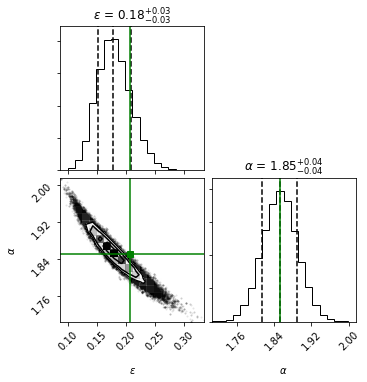

In [9]:
# plot the samples and show if there is any covariance
fig = BFA.show_corner_plot()

In [10]:
# Since the distributions are not quite symmetric instead of median and std we calculate 16, 50, 84 percentiles
BFA.calculate_percentiles() # the first one is for eps, the second for alpha:

[(0.17813200944837654, 0.031355720924743175, 0.027069885446427577),
 (1.8525741381753917, 0.037468499695698654, 0.03775262013469005)]